# Synchrotron Radiation Accelerator Design

This notebook performs comprehensive calculations for a synchrotron radiation accelerator, including beam parameters, synchrotron radiation effects, RF system design, bucket analysis, and optimization.

## Input Parameters

Modify the parameters below to change the accelerator design. All subsequent calculations depend on these values.

In [2]:
import numpy as np
import scipy.constants as PC
import matplotlib.pyplot as plt
import scipy.optimize as scopt
import scipy as sc
import sympy as sp


# Fundamental constants
E0 = 0.511e-3  # Rest energy of electron [GeV]
m_e = PC.m_e * PC.c**2 / (PC.e * 1e9)  # Electron mass [GeV/c^2]

# Accelerator parameters
E = 175.0  # Beam energy [GeV]
rho = 10000.0  # Bending radius [m]
C0 = 100000.0  # Circumference [m]
alpha_c = 7.3e-6  # Momentum compaction factor

# RF system parameters
f_rf = 400e6  # RF frequency [Hz]
phi_s_deg = 110.0  # Synchronous phase [degrees]

# Beam parameters
P_beam = 50e6  # Beam power per beam [W]
n_bunches_est = 3.5e10  # Estimated electrons per bunch

# Cavity parameters
E_grad = 20e6  # Cavity gradient [V/m]
lengths_cryo = 7.0  # Cryomodule length [m]

# Optimization targets
target_E_bk_percent = 3.0  # Target bucket height [% of E]

# Damping partition numbers
jx = 1.0  # Horizontal damping partition
jy = 1.0  # Vertical damping partition
jz = 2.0  # Longitudinal damping partition

In [3]:
# Derived parameters
E_kin = E - E0  # Kinetic energy [GeV]
gamma = E / E0  # Lorentz factor
beta = np.sqrt(1 - 1/gamma**2)  # Relativistic beta
p = beta * E  # Momentum [GeV/c]
B_rho_val = 3.3356 * p  # Magnetic rigidity [Tm]

T_rev = C0 / (beta * PC.c)  # Revolution period [s]
f_rev = 1 / T_rev  # Revolution frequency [Hz]

phi_s = np.radians(phi_s_deg)  # Synchronous phase [rad]

print(f'Beam energy: {E} GeV')
print(f'Lorentz factor: {gamma:.0f}')
print(f'Relativistic beta: {beta:.6f}')
print(f'Momentum: {p:.1f} GeV/c')
print(f'Magnetic rigidity: {B_rho_val:.1f} Tm')
print(f'Revolution frequency: {f_rev:.2f} Hz')

Beam energy: 175.0 GeV
Lorentz factor: 342466
Relativistic beta: 1.000000
Momentum: 175.0 GeV/c
Magnetic rigidity: 583.7 Tm
Revolution frequency: 2997.92 Hz


## Beam Calculations

In [4]:
# Synchrotron radiation energy loss
U0 = PC.e**2 * beta**4 * gamma**4 / (3 * PC.epsilon_0 * rho)  # Energy loss per turn [J]
U0_GeV = U0 / PC.e / 1e9  # [GeV]

# Power radiated by one particle
P_particle = PC.e**2 * PC.c / (6 * np.pi * PC.epsilon_0) * beta**4 * gamma**4 / rho**2  # [W]

# Beam current and number of particles
n_part = P_beam / P_particle  # Total particles per beam
I_b = n_part * PC.e / T_rev  # Beam current [A]

# Estimated number of bunches
n_bunches = n_part / n_bunches_est

print(f'Energy loss per turn: {U0_GeV:.2f} GeV')
print(f'Power per particle: {P_particle * 1e6:.2f} µW')
print(f'Beam current: {I_b * 1e3:.2f} mA')
print(f'Number of bunches: {n_bunches:.0f}')

Energy loss per turn: 8.30 GeV
Power per particle: 6.34 µW
Beam current: 3.79 mA
Number of bunches: 225


## Synchrotron Radiation

In [5]:
# Critical energy
E_c = 3/2 * PC.hbar * PC.c / rho * gamma**3  # [J]
E_c_MeV = E_c / PC.e / 1e6  # [MeV]

# Transition energy
gamma_t = 1 / np.sqrt(alpha_c)
E_t = E0 * gamma_t  # [GeV]

# Cooling requirements
L_arc_tot = 0.8 * C0  # Total arc length [m]
P_cooling = P_beam / L_arc_tot  # Cooling power per unit length [W/m]

print(f'Critical energy: {E_c_MeV:.2f} MeV')
print(f'Transition energy: {E_t:.2f} GeV')
print(f'Cooling required: {P_cooling / 1e3:.3f} kW/m')

Critical energy: 1.19 MeV
Transition energy: 0.19 GeV
Cooling required: 0.625 kW/m


## RF System Design

In [6]:
# RF parameters
h = f_rf / f_rev  # Harmonic number
eta = alpha_c - 1/gamma**2  # Slippage factor

# Minimum RF voltage
V_rf_min = U0 / PC.e  # [V]

# Required RF voltage for synchronous phase
V_rf = V_rf_min / np.sin(phi_s)  # [V]

# Synchrotron tune
Qs = np.sqrt(-V_rf * h * eta * np.cos(phi_s) / (2 * np.pi * beta**2 * E * 1e9))

# Cavity design
length_cell = PC.c / f_rf / 2  # Cell length [m]
Cavity_length = length_cell * 3  # Cavity length (3 cells)
n_cav_per_cryo = int(lengths_cryo / Cavity_length)
V_cryomodule = E_grad * Cavity_length * n_cav_per_cryo  # Voltage per cryomodule [V]
N_cryomodule = V_rf / (4 * V_cryomodule)  # Number of cryomodules

print(f'Harmonic number: {h:.0f}')
print(f'RF voltage: {V_rf / 1e9:.2f} GV')
print(f'Synchrotron tune: {Qs:.5f}')
print(f'Cavities per cryomodule: {n_cav_per_cryo}')
print(f'Number of cryomodules: {N_cryomodule:.2f}')

Harmonic number: 133426
RF voltage: 8.83 GV
Synchrotron tune: 0.05172
Cavities per cryomodule: 6
Number of cryomodules: 16.36


## RF Bucket Analysis

In [7]:
def rf_bucket_acceptance(phi_s):
    """Calculate RF bucket acceptance [eV·s]"""
    V_rf_loc = U0 / (PC.e * np.sin(phi_s))
    h_loc = f_rf / f_rev
    eta_loc = alpha_c - 1/gamma**2
    w_rf = 2 * np.pi * f_rf
    term1 = 8 / w_rf
    term2 = np.sqrt(2 * V_rf_loc * beta**2 * E * 1e9 / (np.pi * h_loc * abs(eta_loc)))
    term3 = (1 - np.sin(phi_s)) / (1 + np.sin(phi_s))
    A_bk = term1 * term2 * term3
    return A_bk

def rf_bucket_height(phi_s):
    """Calculate RF bucket height [eV]"""
    V_rf_loc = U0 / (PC.e * np.sin(phi_s))
    h_loc = f_rf / f_rev
    eta_loc = alpha_c - 1/gamma**2
    term = -np.cos(phi_s) + (np.pi - 2*phi_s)/2 * np.sin(phi_s)
    E_bk = np.sqrt(2 * V_rf_loc * beta**2 * E * 1e9 / (np.pi * h_loc * abs(eta_loc))) * np.sqrt(abs(term))
    return E_bk

# Current bucket parameters
A_bk = rf_bucket_acceptance(phi_s)
E_bk = rf_bucket_height(phi_s)

print(f'RF bucket acceptance: {A_bk:.2f} eV·s')
print(f'RF bucket height: {E_bk / 1e9:.2f} GeV ({E_bk / (E * 1e9) * 100:.2f}%)')

RF bucket acceptance: 3.15 eV·s
RF bucket height: 3.76 GeV (2.15%)


## Optimization for RF Bucket Height

In [8]:
# Target bucket height
target_E_bk = target_E_bk_percent / 100 * E * 1e9  # [eV]

# Optimization
def objective(phi):
    return rf_bucket_height(phi) - target_E_bk

try:
    phi_opt = scopt.brentq(objective, np.pi/2, np.pi)
    V_rf_opt = U0 / (PC.e * np.sin(phi_opt))
    E_bk_check = rf_bucket_height(phi_opt)
    print(f'Optimal synchronous phase: {np.degrees(phi_opt):.1f}°')
    print(f'Optimal RF voltage: {V_rf_opt / 1e9:.2f} GV')
    print(f'Achieved bucket height: {E_bk_check / 1e9:.2f} GeV ({E_bk_check / (E * 1e9) * 100:.2f}%)')
except ValueError:
    print(f'Target {target_E_bk_percent}% not achievable. Maximizing bucket height...')
    result = scopt.minimize_scalar(lambda phi: -rf_bucket_height(phi), bounds=(np.pi/2, np.pi), method='bounded')
    phi_opt = result.x
    E_bk_opt = -result.fun
    V_rf_opt = U0 / (PC.e * np.sin(phi_opt))
    print(f'Optimal synchronous phase: {np.degrees(phi_opt):.1f}°')
    print(f'Maximum bucket height: {E_bk_opt / 1e9:.2f} GeV ({E_bk_opt / (E * 1e9) * 100:.2f}%)')
    print(f'Required RF voltage: {V_rf_opt / 1e9:.2f} GV')

Optimal synchronous phase: 114.8°
Optimal RF voltage: 9.14 GV
Achieved bucket height: 5.25 GeV (3.00%)


## Plots

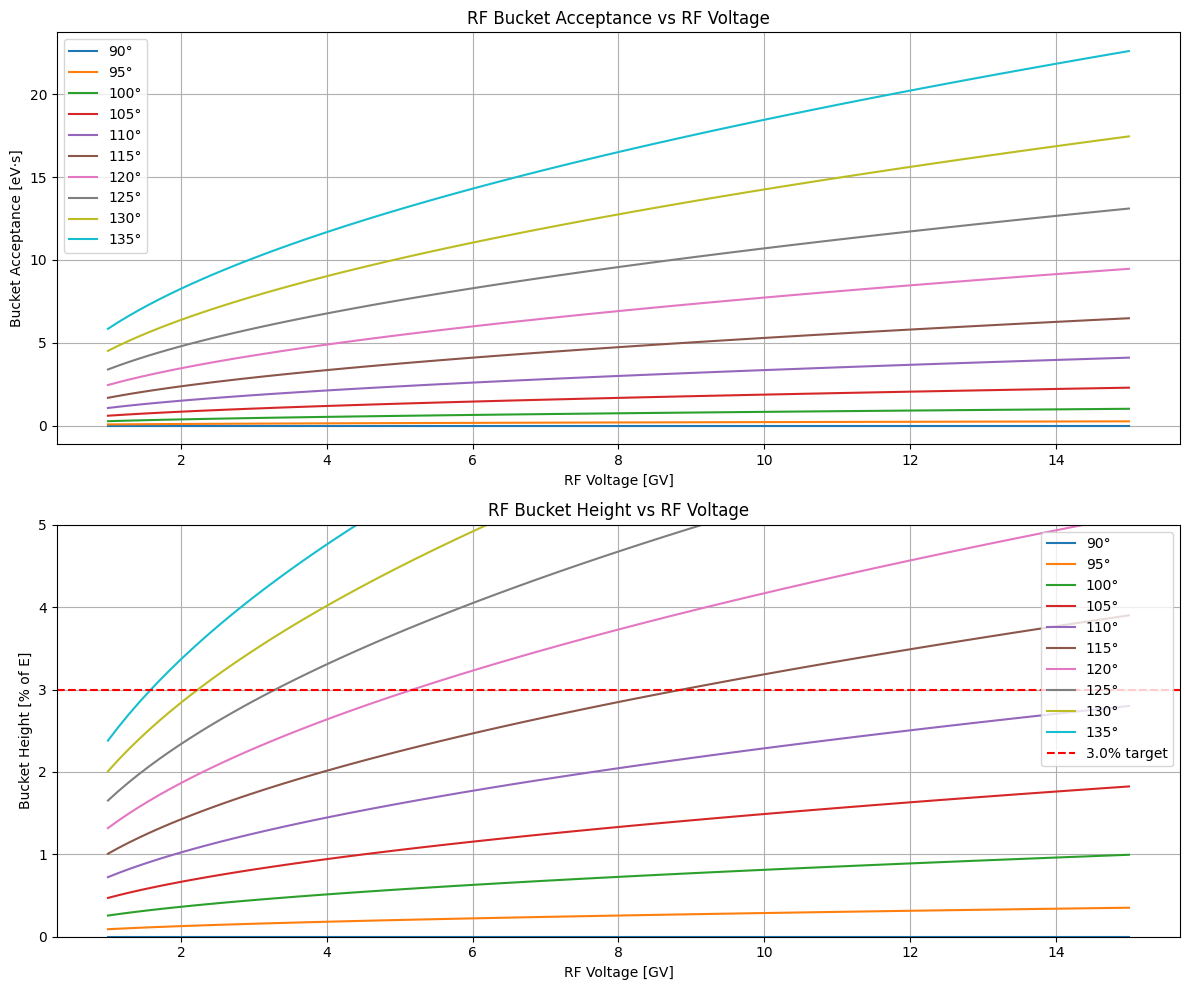

In [9]:
# Plot parameters
V_rf_range = np.linspace(1e9, 15e9, 100)  # [V]
phi_values = np.linspace(np.pi/2, 135/180*np.pi, 10)  # 90° to 135°

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

for phi_s in phi_values:
    A_bk_values = []
    E_bk_values = []
    for V_rf in V_rf_range:
        h_loc = f_rf / f_rev
        eta_loc = alpha_c - 1/gamma**2
        w_rf = 2 * np.pi * f_rf
        term1 = 8 / w_rf
        term2 = np.sqrt(2 * V_rf * beta**2 * E * 1e9 / (np.pi * h_loc * abs(eta_loc)))
        term3 = (1 - np.sin(phi_s)) / (1 + np.sin(phi_s))
        A_bk = term1 * term2 * term3
        term = -np.cos(phi_s) + (np.pi - 2*phi_s)/2 * np.sin(phi_s)
        E_bk = term2 * np.sqrt(abs(term))
        A_bk_values.append(A_bk)
        E_bk_values.append(E_bk / (E * 1e9) * 100)
    ax1.plot(V_rf_range / 1e9, A_bk_values, label=f'{np.degrees(phi_s):.0f}°')
    ax2.plot(V_rf_range / 1e9, E_bk_values, label=f'{np.degrees(phi_s):.0f}°')

ax1.set_xlabel('RF Voltage [GV]')
ax1.set_ylabel('Bucket Acceptance [eV·s]')
ax1.set_title('RF Bucket Acceptance vs RF Voltage')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('RF Voltage [GV]')
ax2.set_ylabel('Bucket Height [% of E]')
ax2.set_title('RF Bucket Height vs RF Voltage')
ax2.legend()
ax2.grid(True)
ax2.set_ylim(0, 5)
ax2.axhline(y=target_E_bk_percent, color='red', linestyle='--', label=f'{target_E_bk_percent}% target')
ax2.legend()

plt.tight_layout()
plt.show()

## Additional Calculations

In [10]:
# Damping times
tau_x = 2/jx * E * 1e9 / (U0 / PC.e) * T_rev
tau_y = 2/jy * E * 1e9 / (U0 / PC.e) * T_rev
tau_z = 2/jz * E * 1e9 / (U0 / PC.e) * T_rev

print(f'Damping times:')
print(f'  Horizontal: {tau_x * 1e3:.2f} ms')
print(f'  Vertical: {tau_y * 1e3:.2f} ms')
print(f'  Longitudinal: {tau_z * 1e3:.2f} ms')

# Equilibrium energy spread
Cq = 55/(32*np.sqrt(3)) * PC.hbar / (PC.m_e * PC.c)
dE_nat = np.sqrt(Cq * gamma**2 / (2 * jz * (C0/(2*np.pi))))

print(f'Equilibrium energy spread: {dE_nat:.5f}')

Damping times:
  Horizontal: 14.07 ms
  Vertical: 14.07 ms
  Longitudinal: 7.04 ms
Equilibrium energy spread: 0.00084


In [11]:
# Bunch length
ratio = dE_nat * E * 1e9 / E_bk
bucket_length = 1 / f_rf
bunch_length = ratio * bucket_length

# Bunch spacing
bunch_spacing = C0 / n_bunches / PC.c

print(f'Bunch length: {bunch_length * 1e9:.2f} ns')
print(f'Bunch spacing: {bunch_spacing * 1e9:.2f} ns')

Bunch length: 0.02 ns
Bunch spacing: 1480.94 ns
